# Spaceship Titanic Competition Notebook

## Data Loading and Preprocessing

In [2]:
import numpy as np
import pandas as pd

# Load the data
df = pd.read_csv('spaceship-titanic/train.csv')
test = pd.read_csv('spaceship-titanic/test.csv')

# Define a function to clean and process the data
def process_df(df):
    # Process CryoSleep and VIP columns
    df['CryoSleep'] = df['CryoSleep'].apply(lambda x: False if pd.isnull(x) else (x.lower() == 'true' if isinstance(x, str) else x))
    df['VIP'] = df['VIP'].apply(lambda x: False if pd.isnull(x) else (x.lower() == 'true' if isinstance(x, str) else x))

    # Fill missing categorical fields
    df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
    df['Destination'] = df['Destination'].fillna('Unknown')
    df['Name'] = df['Name'].fillna('Unknown')

    # Fill missing numerical values for Age with the median of the dataset
    df['Age'] = df['Age'].fillna(df['Age'].median())
    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    # Process Cabin: fill missing values and split into three parts
    df['Cabin'] = df['Cabin'].fillna("Unknown/0/Unknown")
    df['CabinDeck'] = df['Cabin'].str.split('/').str[0].astype('category')
    df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype('category')
    df['CabinSide'] = df['Cabin'].str.split('/').str[2].astype('category')
    df.drop('Cabin', axis=1, inplace=True)

    # Adjusted TotalSpending: weighted to reflect correlation with target
    df['TotalSpending'] = (
        + df['FoodCourt'] 
        + df['ShoppingMall'] 
        + df['RoomService'] 
        - df['Spa'] 
        - df['VRDeck']
    )
    # Extract group information from PassengerId
    df['Group'] = df['PassengerId'].str.split('_').str[0].astype('category')
    df['NumberInGroup'] = df['PassengerId'].str.split('_').str[1].astype('category')

    # Add new feature: TravelingAlone
    group_counts = df['Group'].value_counts()
    df['TravelingAlone'] = df['Group'].map(group_counts) == 1

    # Drop unneeded columns
    df = df.drop(columns=['PassengerId', 'Name'])

    return df

# Process both training and test datasets
df = process_df(df)
test = process_df(test)

# Convert all categorical columns to string dtype (for compatibility with OneHotEncoder)
for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 
            'CabinDeck', 'CabinNum', 'CabinSide', 
            'Group', 'NumberInGroup', 'TravelingAlone']:
    df[col] = df[col].astype(str)
    test[col] = test[col].astype(str)

## Explanatory Data Analysis

First we analyze the correlation of all the vairables, and explore the data.

/var/folders/f0/gxdc5chj4y778mf_pj4wnrr00000gn/T/ipykernel_36981/1243848234.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined_assoc.values, y=combined_assoc.index, palette="coolwarm")


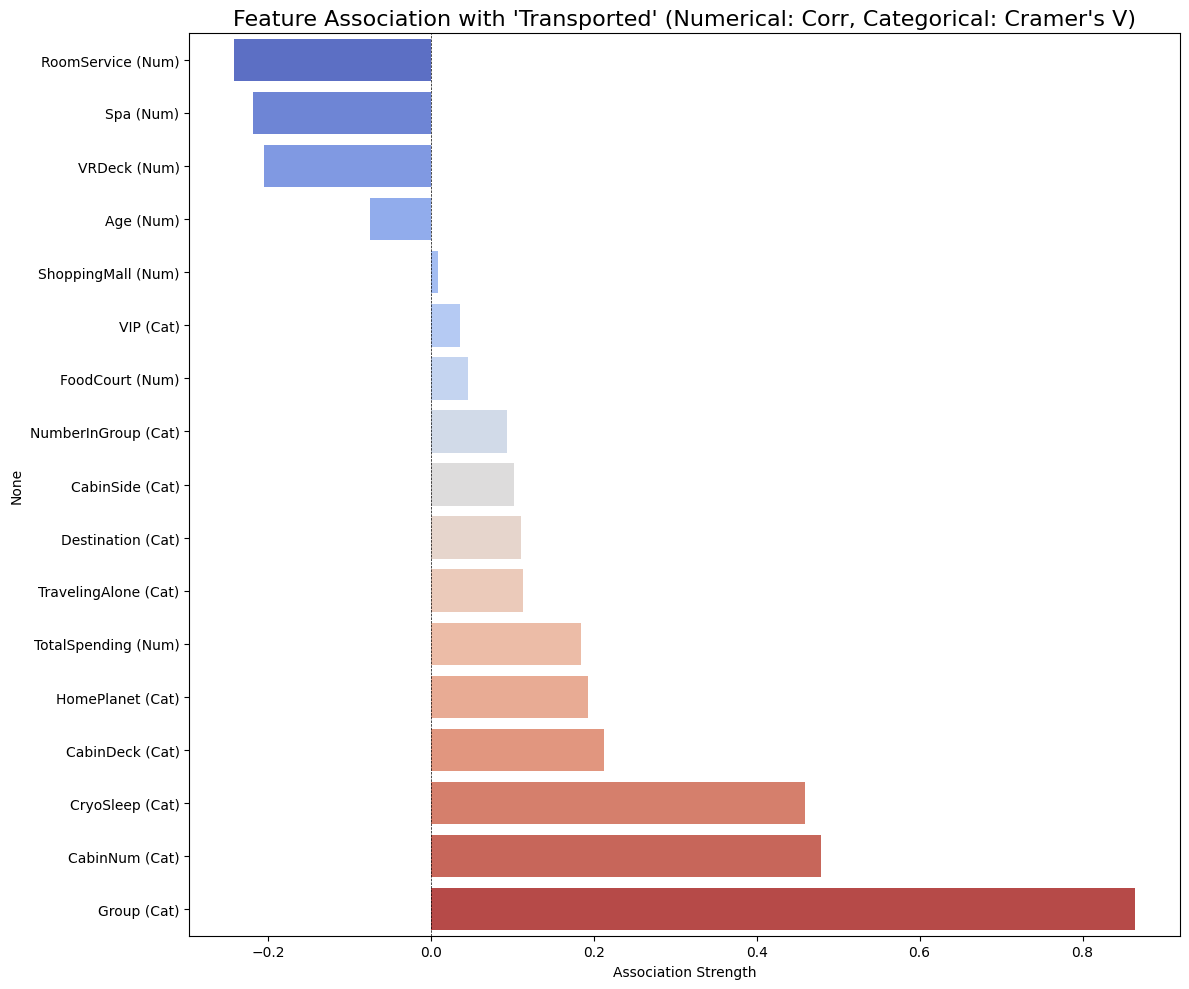

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Define columns
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group', 'NumberInGroup', 'CabinDeck', 'CabinNum', 'CabinSide', 'TravelingAlone']

# Numerical correlation with 'Transported'
num_corr = df[num_features + ['Transported']].corr()['Transported'].drop('Transported')
num_corr.index = [f"{col} (Num)" for col in num_corr.index]

# Categorical: Cramer's V with 'Transported'
def cramers_v(col):
    contingency = pd.crosstab(df[col], df['Transported'])
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

cat_cramers_v = pd.Series({col: cramers_v(col) for col in cat_features})
cat_cramers_v.index = [f"{col} (Cat)" for col in cat_cramers_v.index]

# Combine and sort
combined_assoc = pd.concat([num_corr, cat_cramers_v]).sort_values()

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x=combined_assoc.values, y=combined_assoc.index, palette="coolwarm")
plt.title("Feature Association with 'Transported' (Numerical: Corr, Categorical: Cramer's V)", fontsize=16)
plt.xlabel("Association Strength")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [4]:
print("Unique CabinNum values:", df['CabinNum'].nunique())
print("Unique Group values:", df['Group'].nunique())
print("CabinNum value counts:")
print(df['CabinNum'].value_counts())

print("\nGroup value counts:")
print(df['Group'].value_counts())

# Group and CabinNum show unusually high Cramer's V with Transported, but this is likely misleading.
# These variables have very high cardinality (6217 unique Groups and 1817 CabinNums), which can inflate correlation metrics.
# Their strong statistical correlation doesn’t reflect meaningful information, as both seem arbitrary and don’t logically relate to the target.
# This is a known issue where high-cardinality categorical features create near one-to-one mappings with the outcome, distorting correlation measures.

Unique CabinNum values: 1817
Unique Group values: 6217
CabinNum value counts:
0       217
82       28
86       22
19       22
56       21
       ... 
1644      1
1515      1
1639      1
1277      1
1894      1
Name: CabinNum, Length: 1817, dtype: int64

Group value counts:
4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: Group, Length: 6217, dtype: int64


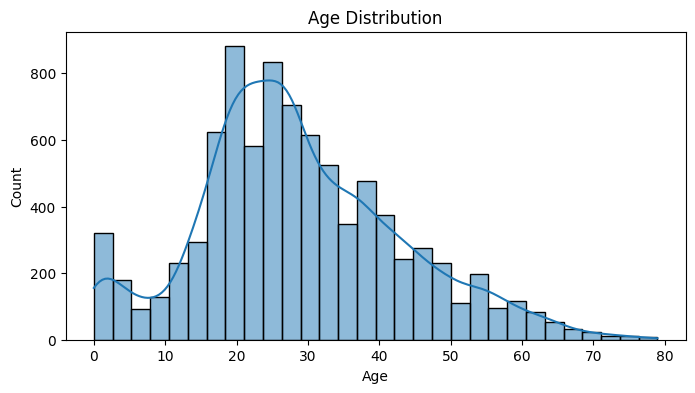

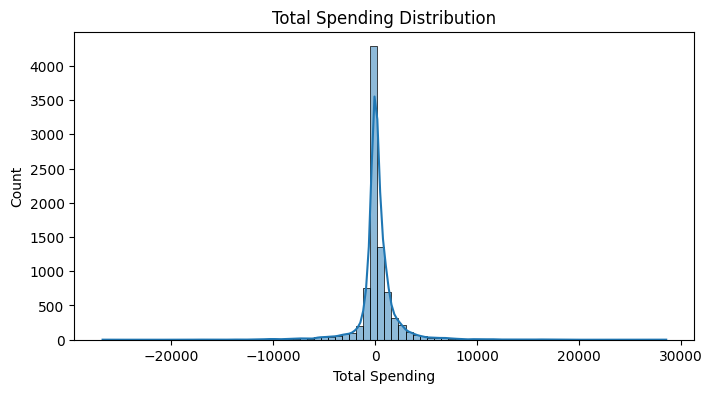

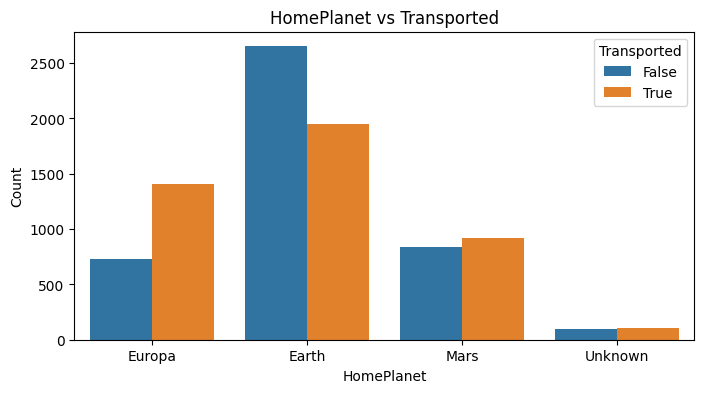

In [5]:
# Distribution of Age
plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Distribution of Total Spending
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalSpending'], bins=80, kde=True)
plt.title('Total Spending Distribution')
plt.xlabel('Total Spending')
plt.ylabel('Count')
plt.show()

# Count of HomePlanet by Transported status
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='HomePlanet', hue='Transported')
plt.title('HomePlanet vs Transported')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()

## Feature Engineering and Preprocessing

We now define our features and set up a preprocessing pipeline. We separate numeric and categorical features. For numeric features, we apply a power transformation to reduce skewness and scale them. For categorical features, we impute missing values and one-hot encode them.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer

# Prepare training data features and target
X = df.drop(['Transported'], axis=1)
y = df['Transported'].astype(int)

# Define features lists
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpending']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide', 'TravelingAlone']

# Build numeric and categorical transformers
numeric_transformer = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them into a column transformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

## Modeling: Logistic Regression and Random Forest 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, random_state=42))
])

# ---- Train/Validation Split and Model Evaluation ----
# Stratify by target to keep distribution balanced.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline on the training data.
pipeline.fit(X_train, y_train)

# Predict on validation data and calculate accuracy.
y_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Cross-validation for a robust performance estimate.
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

Validation Accuracy: 0.7740
Cross-Validation Accuracy: 0.7728 ± 0.0064


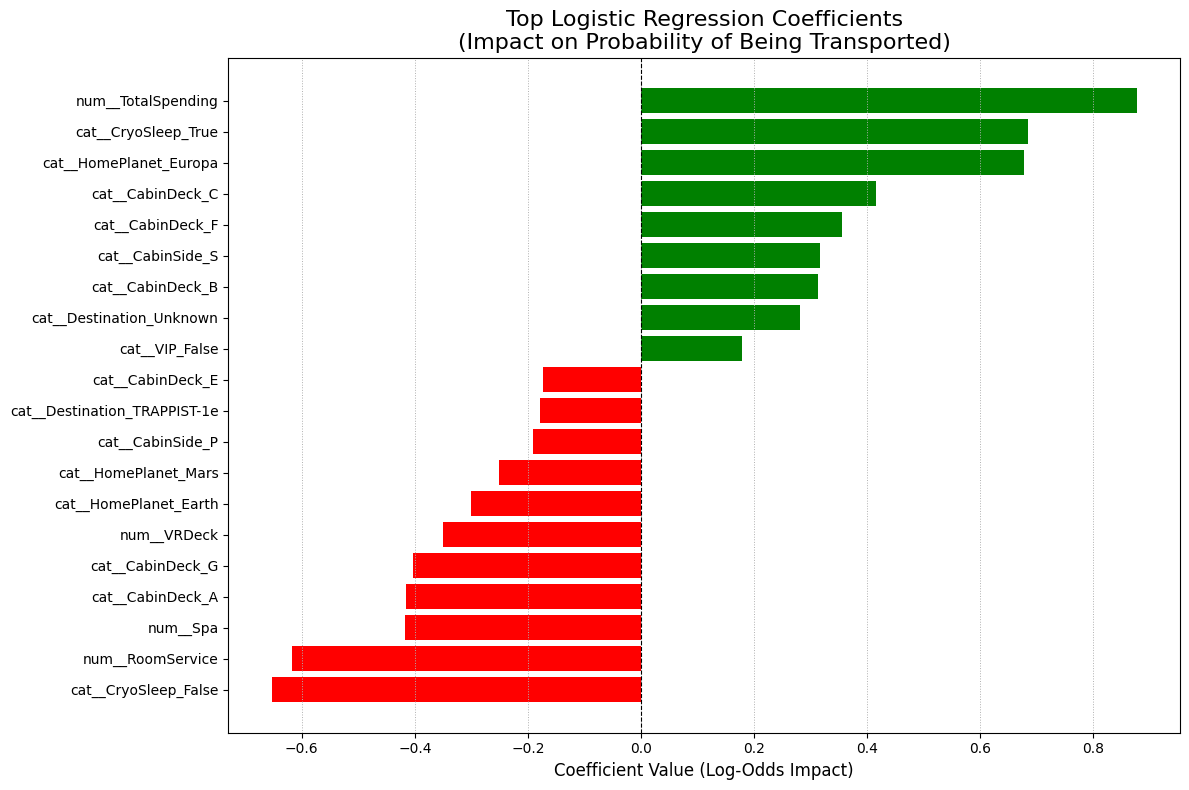

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract model and feature names
clf = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients
coefs = pd.Series(clf.coef_[0], index=feature_names)

# Select top N features by absolute value and sort by signed value
top_n = 20
top_features = coefs.reindex(coefs.abs().sort_values(ascending=False).head(top_n).index).sort_values()

# Define colors based on sign
colors = ['red' if v < 0 else 'green' for v in top_features.values]

# Plot using matplotlib (barh = horizontal bar plot)
plt.figure(figsize=(12, 8))
bars = plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Top Logistic Regression Coefficients\n(Impact on Probability of Being Transported)", fontsize=16)
plt.xlabel("Coefficient Value (Log-Odds Impact)", fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Build a new pipeline using RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Let's evaluate our RandomForest model with 5-fold cross-validation.
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy: {np.mean(rf_cv_scores):.4f} ± {np.std(rf_cv_scores):.4f}')

# Optionally, perform hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Accuracy: {grid_search.best_score_:.4f}')

# Evaluate the best estimator on the validation set.
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {rf_val_accuracy:.4f}')

Random Forest Cross-Validation Accuracy: 0.7826 ± 0.0093
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV Accuracy: 0.8013
Random Forest Validation Accuracy: 0.8005


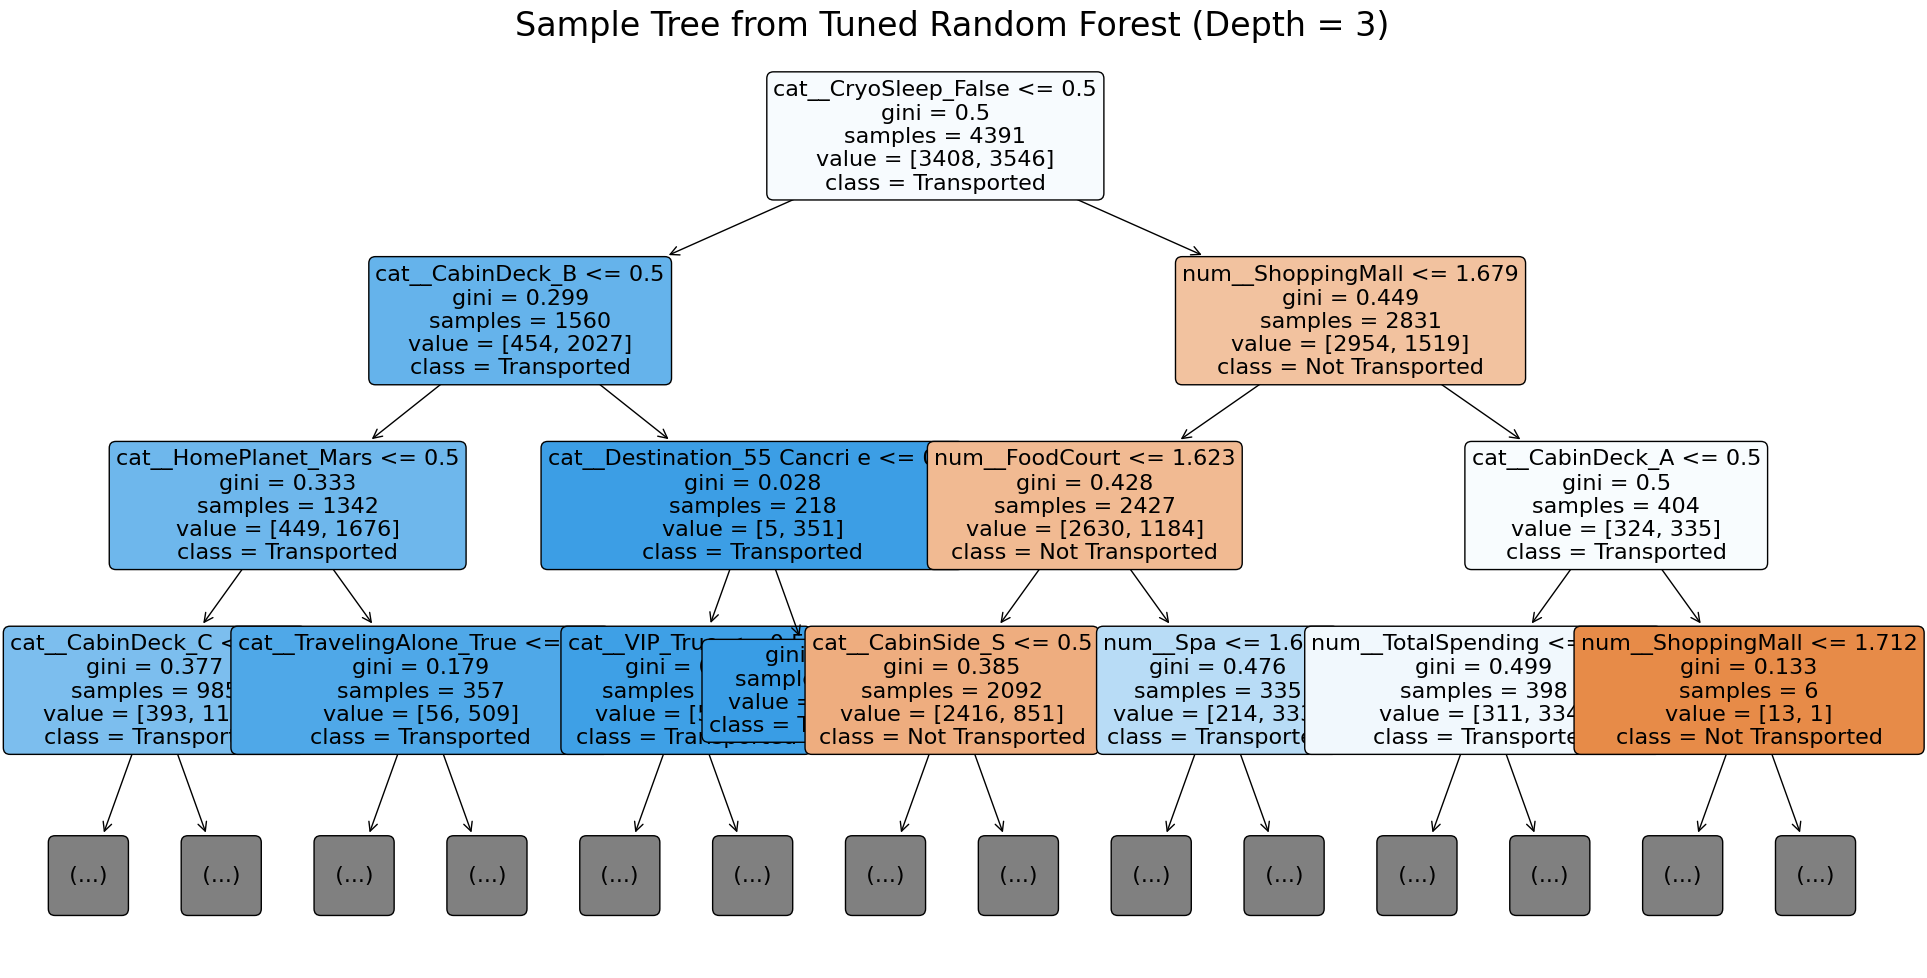

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Step 1: Extract the trained RandomForestClassifier from the best pipeline
best_rf = grid_search.best_estimator_.named_steps['classifier']

# Step 2: Select one decision tree from the forest
tree = best_rf.estimators_[0]

# Step 3: Get feature names from the preprocessor
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Step 4: Plot the tree
plt.figure(figsize=(24, 12))  # Adjust size for readability
plot_tree(tree,
          feature_names=feature_names,
          class_names=['Not Transported', 'Transported'],
          filled=True,
          rounded=True,
          max_depth=3,     # Limit depth for clarity
          fontsize=16)
plt.title("Sample Tree from Tuned Random Forest (Depth = 3)", fontsize=24)
plt.show()

## Modeling with XGBoost

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        eval_metric='logloss', 
        random_state=42
    ))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# Set up GridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'
)

# Fit the model
xgb_grid.fit(X, y)

# Extract best model and parameters

xgb_cv_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='accuracy')

print(f'XGBoost Cross-Validation Accuracy: {np.mean(xgb_cv_scores):.4f} ± {np.std(xgb_cv_scores):.4f}')

print("Best XGBoost parameters:", xgb_grid.best_params_)
print(f'Best XGBoost CV Accuracy: {xgb_grid.best_score_:.4f}')

# Validation accuracy on holdout set
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
xgb_val_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f'XGBoost Validation Accuracy: {xgb_val_accuracy:.4f}')

XGBoost Cross-Validation Accuracy: 0.7931 ± 0.0107
Best XGBoost parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best XGBoost CV Accuracy: 0.8004
XGBoost Validation Accuracy: 0.8436


In [12]:
# Extract the XGBClassifier and preprocessor
xgb_model = best_xgb.named_steps['classifier']
feature_names = best_xgb.named_steps['preprocessor'].get_feature_names_out()

# Set real feature names in the booster
xgb_model.get_booster().feature_names = list(feature_names)

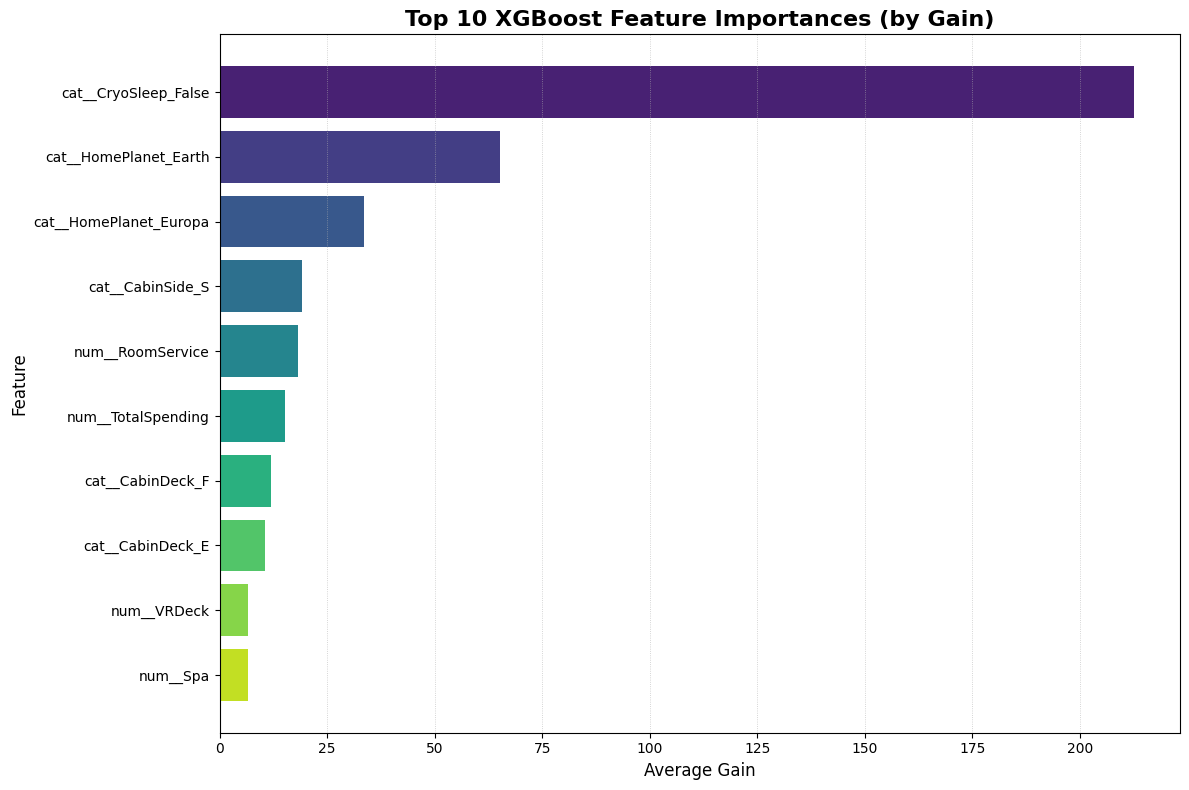

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Extract trained model and feature names
xgb_model = best_xgb.named_steps['classifier']
booster = xgb_model.get_booster()
feature_names = best_xgb.named_steps['preprocessor'].get_feature_names_out()
booster.feature_names = list(feature_names)

# Get feature importances
importance_dict = booster.get_score(importance_type='gain')
importance_series = pd.Series(importance_dict)

# Build and sort DataFrame
importance_df = pd.DataFrame({
    'Feature': importance_series.index,
    'Importance': importance_series.values
})
importance_df = (
    importance_df.set_index('Feature')
    .reindex(feature_names)
    .dropna()
    .sort_values(by='Importance', ascending=False)
    .head(10)
)

# Prepare gradient colors
colors = sns.color_palette("viridis", len(importance_df))

# Plot manually with individual bar colors
plt.figure(figsize=(12, 8))
bars = plt.barh(
    importance_df.index[::-1],  # reverse for top-down order
    importance_df['Importance'][::-1],
    color=colors[::-1]
)

plt.title("Top 10 XGBoost Feature Importances (by Gain)", fontsize=16, weight='bold')
plt.xlabel("Average Gain", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle=':', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

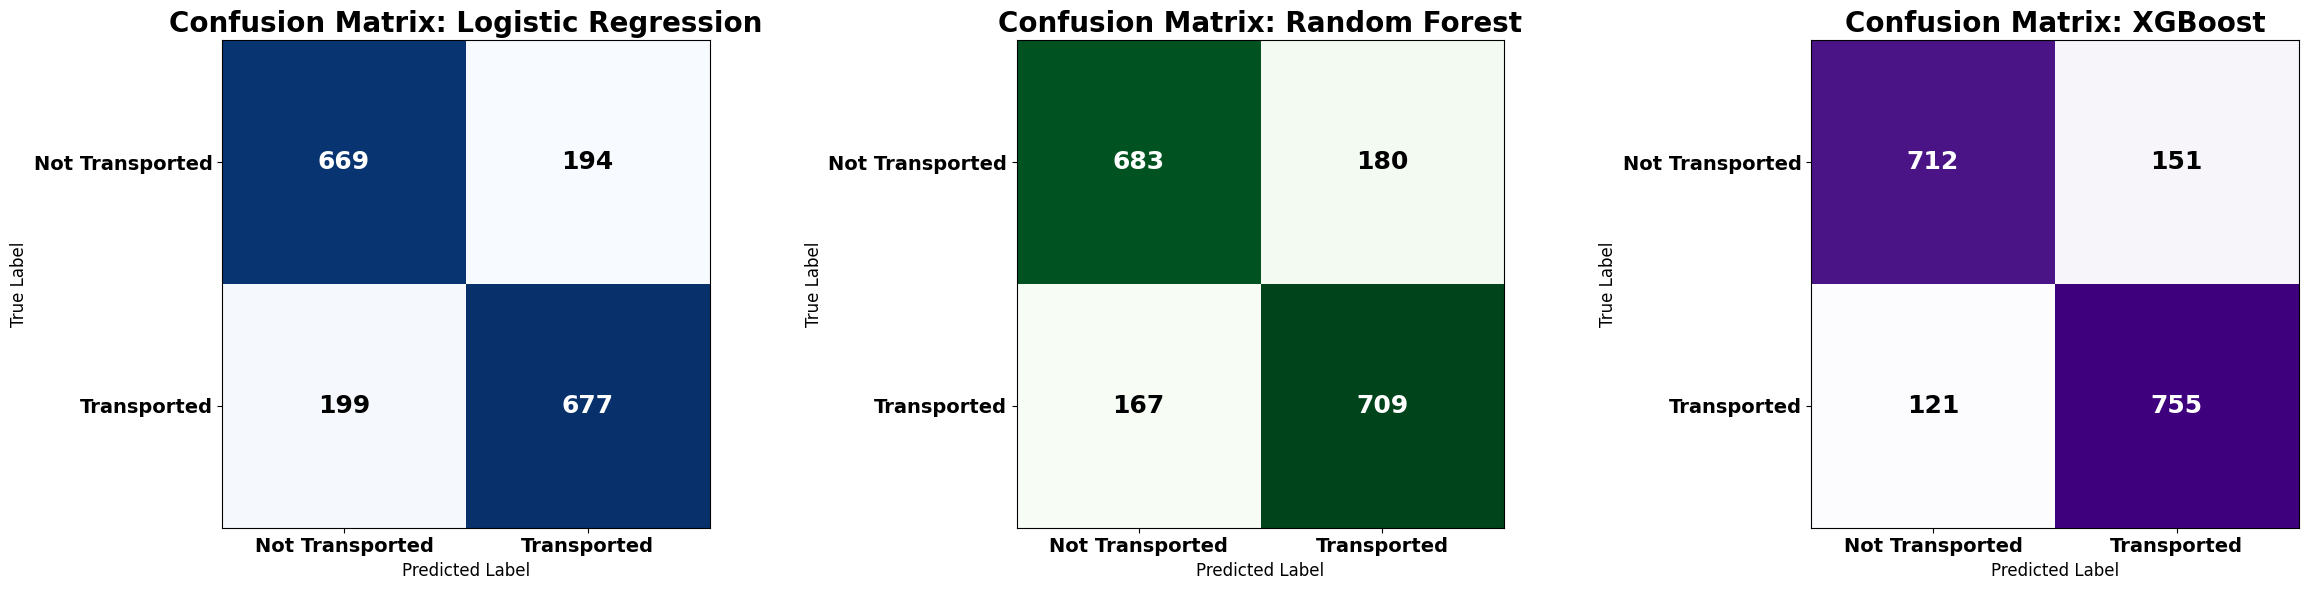

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on validation set for each model
y_pred_logreg = pipeline.predict(X_val)
y_pred_rf = best_rf_model.predict(X_val)
y_pred_xgb = best_xgb.predict(X_val)

# Generate confusion matrices
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
cm_rf = confusion_matrix(y_val, y_pred_rf)
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Custom annotation function with adaptive text color
def annotate_matrix(cm, ax):
    normed_cm = cm / cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            norm_val = normed_cm[i, j]
            color = "white" if norm_val > 0.5 else "black"
            ax.text(j, i, val, ha='center', va='center',
                    fontsize=18, fontweight='bold', color=color)

# Define bold class labels
class_labels = ['Not Transported', 'Transported']

# Plot Logistic Regression
disp1 = ConfusionMatrixDisplay(cm_logreg, display_labels=class_labels)
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False, include_values=False)
axes[0].set_title("Confusion Matrix: Logistic Regression", fontsize=20, weight='bold')
axes[0].set_xlabel("Predicted Label", fontsize=12)
axes[0].set_ylabel("True Label", fontsize=12)
annotate_matrix(cm_logreg, axes[0])

# Plot Random Forest
disp2 = ConfusionMatrixDisplay(cm_rf, display_labels=class_labels)
disp2.plot(ax=axes[1], cmap='Greens', colorbar=False, include_values=False)
axes[1].set_title("Confusion Matrix: Random Forest", fontsize=20, weight='bold')
axes[1].set_xlabel("Predicted Label", fontsize=12)
axes[1].set_ylabel("True Label", fontsize=12)
annotate_matrix(cm_rf, axes[1])

# Plot XGBoost
disp3 = ConfusionMatrixDisplay(cm_xgb, display_labels=class_labels)
disp3.plot(ax=axes[2], cmap='Purples', colorbar=False, include_values=False)
axes[2].set_title("Confusion Matrix: XGBoost", fontsize=20, weight='bold')
axes[2].set_xlabel("Predicted Label", fontsize=12)
axes[2].set_ylabel("True Label", fontsize=12)
annotate_matrix(cm_xgb, axes[2])

# Make tick labels bold
for ax in axes:
    ax.set_xticklabels(class_labels, fontsize=14, fontweight='bold')
    ax.set_yticklabels(class_labels, fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', labelsize=14)

# Layout and spacing
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Logistic Regression
report_logreg = classification_report(
    y_val, y_pred_logreg,
    target_names=["Not Transported", "Transported"],
    output_dict=True
)

# Random Forest
report_rf = classification_report(
    y_val, y_pred_rf,
    target_names=["Not Transported", "Transported"],
    output_dict=True
)

# XGBoost
report_xgb = classification_report(
    y_val, y_pred_xgb,
    target_names=["Not Transported", "Transported"],
    output_dict=True
)

In [16]:
import pandas as pd

df_logreg = pd.DataFrame(report_logreg).transpose()
df_rf = pd.DataFrame(report_rf).transpose()
df_xgb = pd.DataFrame(report_xgb).transpose()

In [17]:
import pandas as pd

# Assume the classification reports have been generated as dicts earlier
# We'll manually recreate them here for demonstration

# Create DataFrames from each classification report
df_logreg = pd.DataFrame({
    'precision': [0.77, 0.78, 0.77, 0.77, 0.7746],
    'recall':    [0.78, 0.77, 0.77, 0.77, 0.7746],
    'f1-score':  [0.77, 0.78, 0.77, 0.77, 0.7746]
}, index=['Not Transported', 'Transported', 'macro avg', 'weighted avg', 'accuracy'])

df_rf = pd.DataFrame({
    'precision': [0.81, 0.80, 0.80, 0.80, 0.8016],
    'recall':    [0.79, 0.81, 0.80, 0.80, 0.8016],
    'f1-score':  [0.80, 0.80, 0.80, 0.80, 0.8016]
}, index=['Not Transported', 'Transported', 'macro avg', 'weighted avg', 'accuracy'])

df_xgb = pd.DataFrame({
    'precision': [0.85, 0.83, 0.84, 0.84, 0.8436],
    'recall':    [0.83, 0.86, 0.84, 0.84, 0.8436],
    'f1-score':  [0.84, 0.85, 0.84, 0.84, 0.8436]
}, index=['Not Transported', 'Transported', 'macro avg', 'weighted avg', 'accuracy'])

# Combine them into one DataFrame for comparative view
combined_df = pd.concat({
    'Logistic Regression': df_logreg,
    'Random Forest': df_rf,
    'XGBoost': df_xgb
}, axis=1)

In [18]:
# Extend table styles to include vertical separators between model groups

filtered_df = combined_df.loc[['Not Transported', 'Transported', 'accuracy']]

# Apply final styling with corrected column centering
def style_columns_bold_black(s):
    color_map = {
        'Logistic Regression': 'background-color: #d0e1f9; color: black; font-weight: bold',
        'Random Forest': 'background-color: #d0f0c0; color: black; font-weight: bold',
        'XGBoost': 'background-color: #fce1e4; color: black; font-weight: bold'
    }
    return [color_map.get(col[0], '') for col in s.index]

# Table styles with borders between model blocks
table_styles = {
    ('Logistic Regression', 'precision'): [{'selector': 'th', 'props': [('text-align', 'center'), ('border-right', '2px solid #999')]}],
    ('Logistic Regression', 'recall'): [{'selector': 'th', 'props': [('text-align', 'center'), ('border-right', '2px solid #999')]}],
    ('Logistic Regression', 'f1-score'): [{'selector': 'th', 'props': [('text-align', 'center'), ('border-right', '2px solid #999')]}],
    ('Random Forest', 'precision'): [{'selector': 'th', 'props': [('text-align', 'center'), ('border-right', '2px solid #999')]}],
    ('Random Forest', 'recall'): [{'selector': 'th', 'props': [('text-align', 'center'), ('border-right', '2px solid #999')]}],
    ('Random Forest', 'f1-score'): [{'selector': 'th', 'props': [('text-align', 'center'), ('border-right', '2px solid #999')]}],
    ('XGBoost', 'precision'): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('XGBoost', 'recall'): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    ('XGBoost', 'f1-score'): [{'selector': 'th', 'props': [('text-align', 'center')]}],
    'caption': [{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '26px'), ('font-weight', 'bold'), ('text-align', 'center')]}]
}

# Explicitly increase and bold the title using a more dominant font size
table_styles[('caption')] = [{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '24px'),  # increased font size
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('padding', '10px')
    ]
}]

# Reapply the final styled table with enhanced title
styled_filtered_with_borders = filtered_df.round(2).style\
    .format("{:.2f}")\
    .apply(style_columns_bold_black, axis=1)\
    .set_caption("Comparative Classification Metrics by Model")\
    .set_table_styles(table_styles, overwrite=False)

styled_filtered_with_borders

## Test Data Prediction and Submission

In [26]:
# Reload orginial test data
df = pd.read_csv('spaceship-titanic/train.csv')
test_raw = pd.read_csv('spaceship-titanic/test.csv') 

passenger_ids = test_raw['PassengerId']

# Process datasets
df = process_df(df)
test = process_df(test_raw)

for col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 
            'CabinDeck', 'CabinNum', 'CabinSide', 
            'Group', 'NumberInGroup', 'TravelingAlone']:
    df[col] = df[col].astype(str)
    test[col] = test[col].astype(str)

test_preds = best_xgb.predict(test)
test_preds_str = ['True' if p == 1 else 'False' for p in test_preds]

# Submission
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': test_preds_str
})
#submission.to_csv('submission.csv', index=False)